# ***Initialization***

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# ***Importing Database***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5991 entries, 0 to 5990
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5991 non-null   object 
 1   Open       5991 non-null   int64  
 2   High       5991 non-null   int64  
 3   Low        5991 non-null   int64  
 4   Close      5991 non-null   int64  
 5   Adj Close  5991 non-null   float64
 6   Volume     5991 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 327.8+ KB


Text(0, 0.5, 'Price')

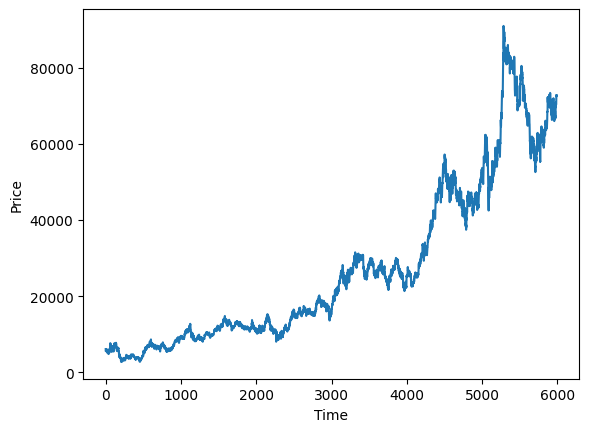

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Rifat-87/Assignment-3-RNN/main/005930.KS.csv')
df.info()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.fillna(method='ffill', inplace=True)
df1=df.reset_index()['Close']
plt.plot(df1)
plt.xlabel('Time')
plt.ylabel('Price')

In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-15,71600,72200,71500,72200,72200.0,20148677
2023-11-16,72500,73000,72300,72800,72800.0,15860451
2023-11-17,72300,73000,72300,72500,72500.0,11494644
2023-11-20,72100,73000,72100,72700,72700.0,10610157
2023-11-21,73100,73400,72700,72800,72800.0,9712881


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/100
4010/4010 [==============================] - 17s 3ms/step - loss: 0.0017
Epoch 2/100
4010/4010 [==============================] - 10s 2ms/step - loss: 0.0012
Epoch 3/100
4010/4010 [==============================] - 10s 3ms/step - loss: 0.0011
Epoch 4/100
4010/4010 [==============================] - 11s 3ms/step - loss: 0.0011
Epoch 5/100
4010/4010 [==============================] - 10s 3ms/step - loss: 0.0011
Epoch 6/100
4010/4010 [==============================] - 10s 2ms/step - loss: 0.0011
Epoch 7/100
4010/4010 [==============================] - 11s 3ms/step - loss: 0.0011
Epoch 8/100
4010/4010 [==============================] - 11s 3ms/step - loss: 0.0011
Epoch 9/100
4010/4010 [==============================] - 10s 2ms/step - loss: 0.0011
Epoch 10/100
4010/4010 [==============================] - 11s 3ms/step - loss: 0.0011
Epoch 11/100
4010/4010 [==============================] - 11s 3ms/step - loss: 0.0011
Epoch 12/100
4010/4010 [==============================] - 10s 3

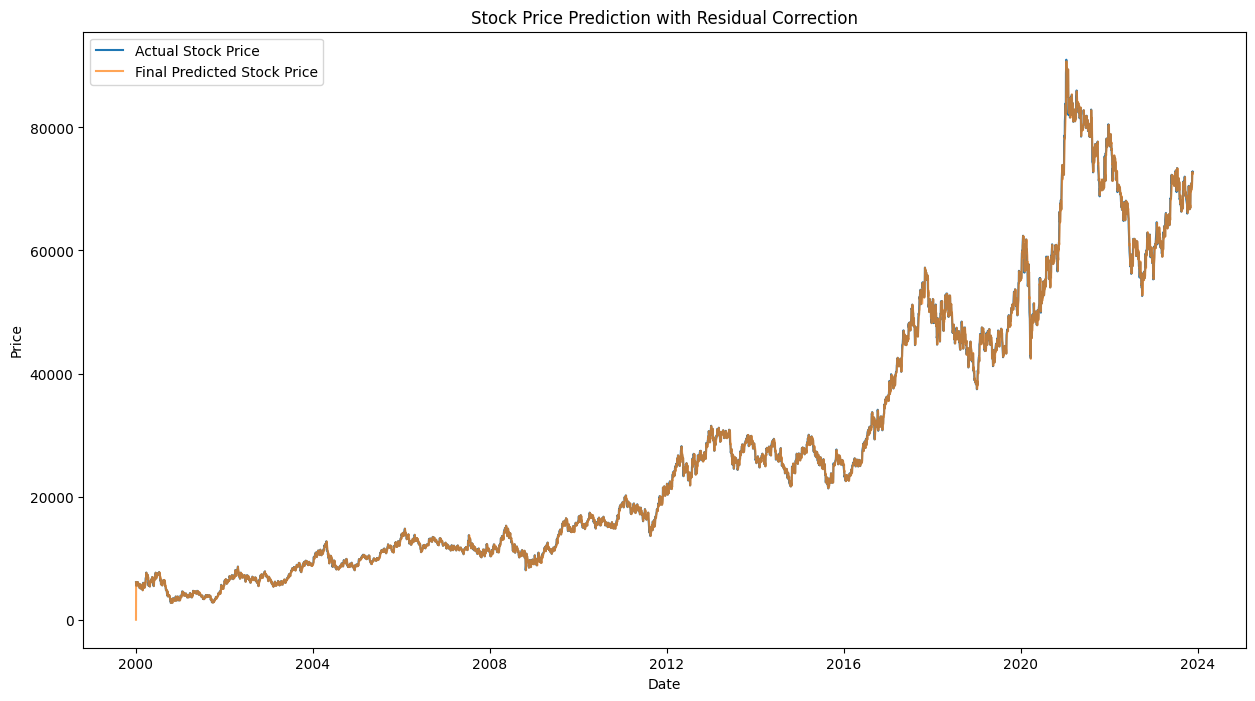

In [5]:
arima_model = ARIMA(df['Close'], order=(5, 1, 0))
arima_result = arima_model.fit()
df['ARIMA_Predictions'] = arima_result.predict(start=0, end=len(df) - 1, typ='levels')
df['Residuals'] = df['Close'] - df['ARIMA_Predictions']
scaler = MinMaxScaler(feature_range=(0, 1))
df['Normalized_Residuals'] = scaler.fit_transform(df[['Residuals']])
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 5
X, Y = create_dataset(df['Normalized_Residuals'].values, look_back)


train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:]
trainY, testY = Y[0:train_size], Y[train_size:]


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)


predicted_residuals = np.append(trainPredict.flatten(), testPredict.flatten())
predicted_residuals = np.concatenate((np.zeros(look_back), predicted_residuals))
df['RNN_Predicted_Residuals'] = predicted_residuals[:len(df)]

df['Final_Predictions'] = df['ARIMA_Predictions'] + df['RNN_Predicted_Residuals']

plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label='Actual Stock Price')
plt.plot(df['Final_Predictions'], label='Final Predicted Stock Price', alpha=0.7)
plt.title('Stock Price Prediction with Residual Correction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
